In [1]:
import sys

sys.path.append("../")
from config.get_config import get_config

# Load Data

In [2]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import mlflow
import shap
import numpy as np
from random import randint

from sklearn.metrics import mean_squared_error

In [3]:
sys.path.append("../src")
from pipeline.factory import Factory
from preprocessing.process_raw_data import load_data

config = dict(get_config())
data_config = dict(config["data"])

mlflow.set_tracking_uri("http://0.0.0.0:5000")
e = mlflow.set_experiment(data_config["mlflow_experiment_name"])

2024-02-09 13:28:34.915371: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-09 13:28:34.952312: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-09 13:28:34.952341: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-09 13:28:34.952355: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-09 13:28:34.960990: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-09 13:28:34.961907: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [4]:
# fix paths
for k, v in data_config["paths"].items():
    if k == "scaler" or k == "optim":
        continue
    for k2, v2 in v.items():
        data_config["paths"][k][k2] = "../" + v2

In [5]:
df_or = load_data(data_config["paths"])
f = Factory(data_config)
f.fit(df_or)

Fitting data ...



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Data Viz

In [6]:
train, val = f.get_df()
data = pd.concat([train, val])

In [7]:
train.head()

,onpromotion,dcoilwtico,cluster,sales,typedays_Additional,typedays_Event,typedays_Holiday,typedays_Normal
2013-01-01,0.0,0.792965,0.0,2511.618999,False,False,True,False
2013-01-02,0.0,0.792965,0.0,496092.417944,False,False,False,True
2013-01-03,0.0,0.790951,0.0,361461.231124,False,False,False,True
2013-01-04,0.0,0.792728,0.0,354459.677093,False,False,False,True
2013-01-05,0.0,0.793044,0.0,348347.385084,False,False,False,True


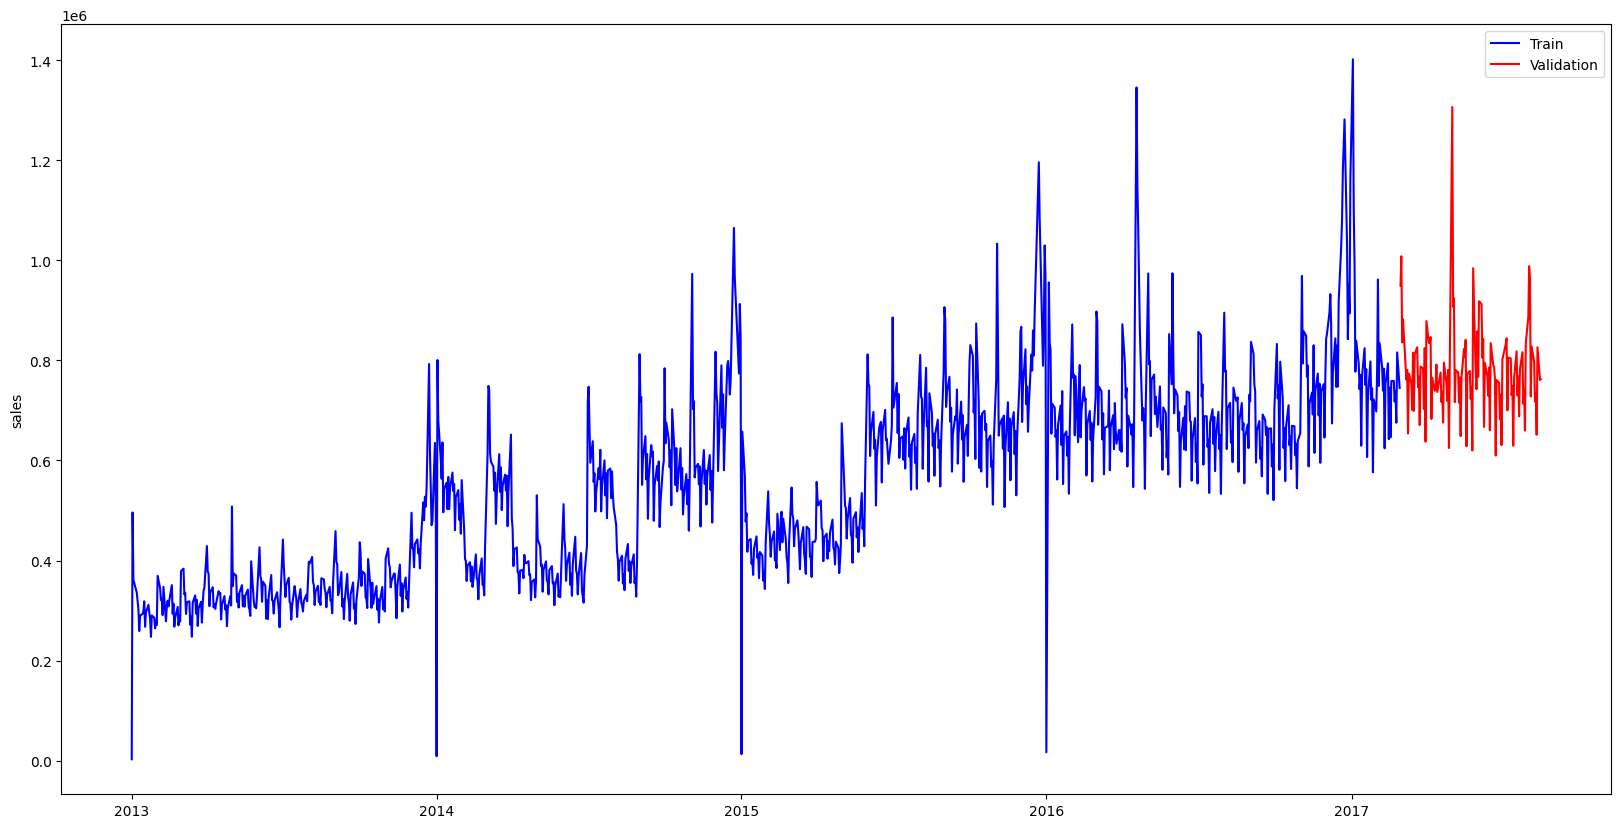

In [8]:
plt.figure(figsize=(20, 10))
sns.lineplot(data=train, x=train.index, y="sales", color="blue", label="Train")
sns.lineplot(data=val, x=val.index, y="sales", color="red", label="Validation")
plt.legend()

# Models fit

In [9]:
def load_model(f: Factory, model_name, use_mlflow=True):
    model_type = model_name.split(" ")[0]
    model = model_name.split(" ")[1]
    #id = (
    #    mlflow.search_registered_models(filter_string=f"name = '{model_name}'")[0]
    #    .latest_versions[0]
    #    .run_id
    #)
    id = f"{model_name}.h5"
    local_config = config[model_type][model]

    f.load_model(id, local_config, use_mlflow)
    f.build_generator(include_val_df=True)
    
    return f

## Xgboost with earthquake features

In [10]:
f = load_model(f, "xgboost best_params_earthquake - 2024-02-07 14:40", False)

model = f.get_model()
X, y = f.get_generator()

In [11]:
shap.initjs()

In [12]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X, y=y.values)
shap_obj = explainer(X)

[13:28:41] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


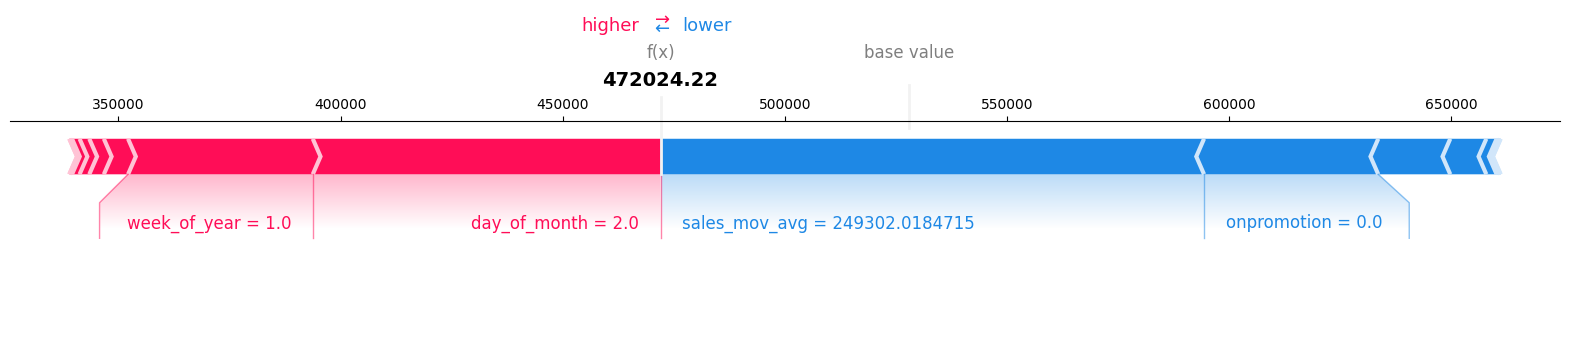

In [13]:
shap.force_plot(explainer.expected_value, shap_values[1,:], X.iloc[1,:], matplotlib=True)

Ce graphe nous montre les features qui contribuent à faire bouger la valeur de base du modèle (soit la sortie moyenne). Les features qui poussent la prediction à la hausse sont en rouge :
* On est le 1er jour du mois
* Année 2014

Les features qui poussent la prédiction à la baisse sont elles en bleu :
* La moyenne sur la semaine est bcp plus basse
* On est un jeudi
* Peu de produits en promo

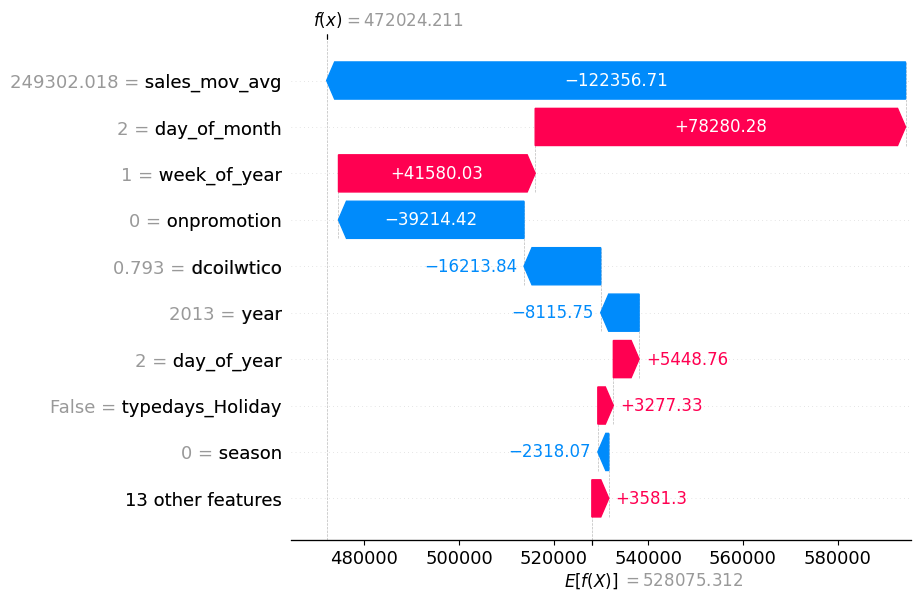

In [14]:
shap.waterfall_plot(shap_obj[1])

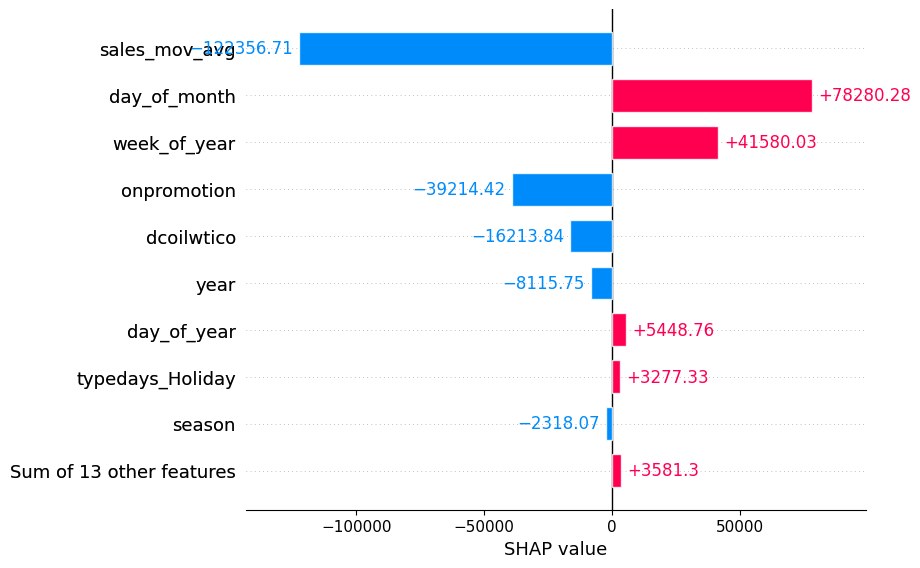

In [15]:
shap.plots.bar(shap_obj[1])

Autre manière de voir la chose

In [16]:
shap.force_plot(explainer.expected_value, shap_values, X)

Order by `Orignal sample ordering`\
Ici, on voit dans le temps l'évolution de l'impact de chacune des variables (on peut selectionner la variable à examiner sur le menu déroulant à gauche. Si f(x) -> on voit le y)

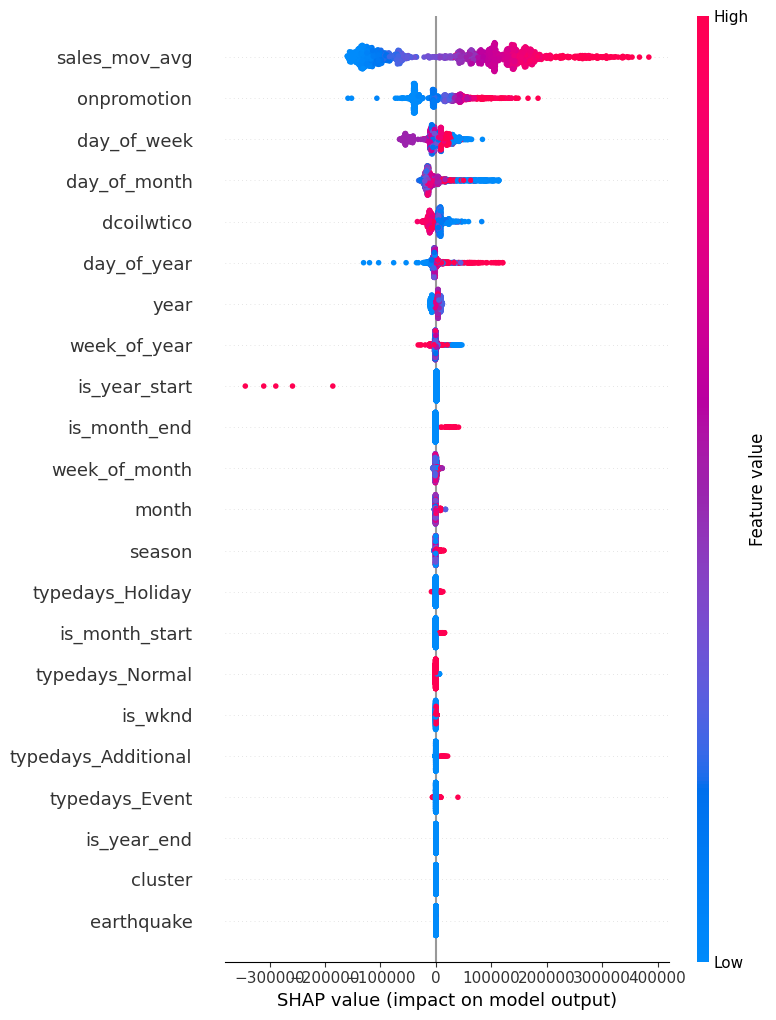

In [17]:
shap.summary_plot(shap_values, X, max_display=30)

Une plus grande dispersion ou une plus forte densité de points indique une variabilité plus importante ou un impact plus minime sur les prévisions du modèle. Cela permet d'évaluer l'importance de la contribution des caractéristiques aux résultats du modèle.

Les couleurs indique l'influence positive ou négative.

On remarque ici que certaines variables semblent inutiles à la prédiction (cluster, is_year_end). Mais ce graph n'est pas suffisant pour le déterminer, ex: earthquake qui a une influence significative par expériences.

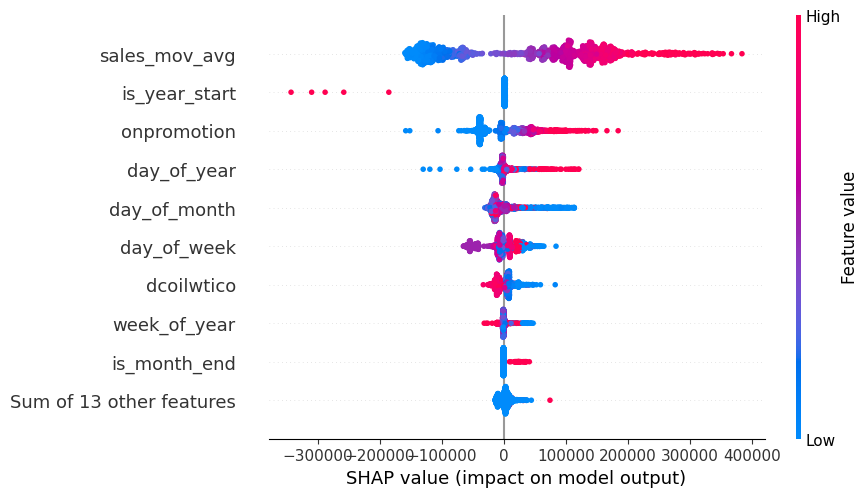

In [18]:
shap.plots.beeswarm(shap_obj, order=shap_obj.abs.max(0))

Le tri des features sur la base de la valeur absolue maximale des valeurs SHAP révèle les features les plus influentes : moyenne sur 7j, jour du mois, jour de la semaine, le nb de promo et le prix de l'escence.

# Variable earthquake

In [20]:
df = X.copy()

In [21]:
df['counter'] = range(len(df))

In [22]:
df[df['earthquake']==1]

,onpromotion,dcoilwtico,cluster,typedays_Additional,typedays_Event,typedays_Holiday,typedays_Normal,month,day_of_month,day_of_year,...,year,is_wknd,is_month_start,is_month_end,is_year_start,is_year_end,season,sales_mov_avg,earthquake,counter
2016-04-16,0.277863,0.165699,0.0,False,False,False,True,4,16,107,...,2016,1,0,0,0,0,1,681599.299660,1,1201
2016-04-17,0.214785,0.163094,0.0,False,False,False,True,4,17,108,...,2016,1,0,0,0,0,1,745362.270404,1,1202
2016-04-18,0.151707,0.160488,0.0,False,True,False,False,4,18,109,...,2016,0,0,0,0,0,1,842586.790540,1,1203
2016-04-19,0.227467,0.173990,0.0,False,True,False,False,4,19,110,...,2016,0,0,0,0,0,1,914077.101086,1,1204


In [23]:
df[df.index==pd.to_datetime("2017-04-16")]

,onpromotion,dcoilwtico,cluster,typedays_Additional,typedays_Event,typedays_Holiday,typedays_Normal,month,day_of_month,day_of_year,...,year,is_wknd,is_month_start,is_month_end,is_year_start,is_year_end,season,sales_mov_avg,earthquake,counter
2017-04-16,0.378532,0.314728,0.0,False,False,False,True,4,16,106,...,2017,1,0,0,0,0,1,754133.592269,0,1566


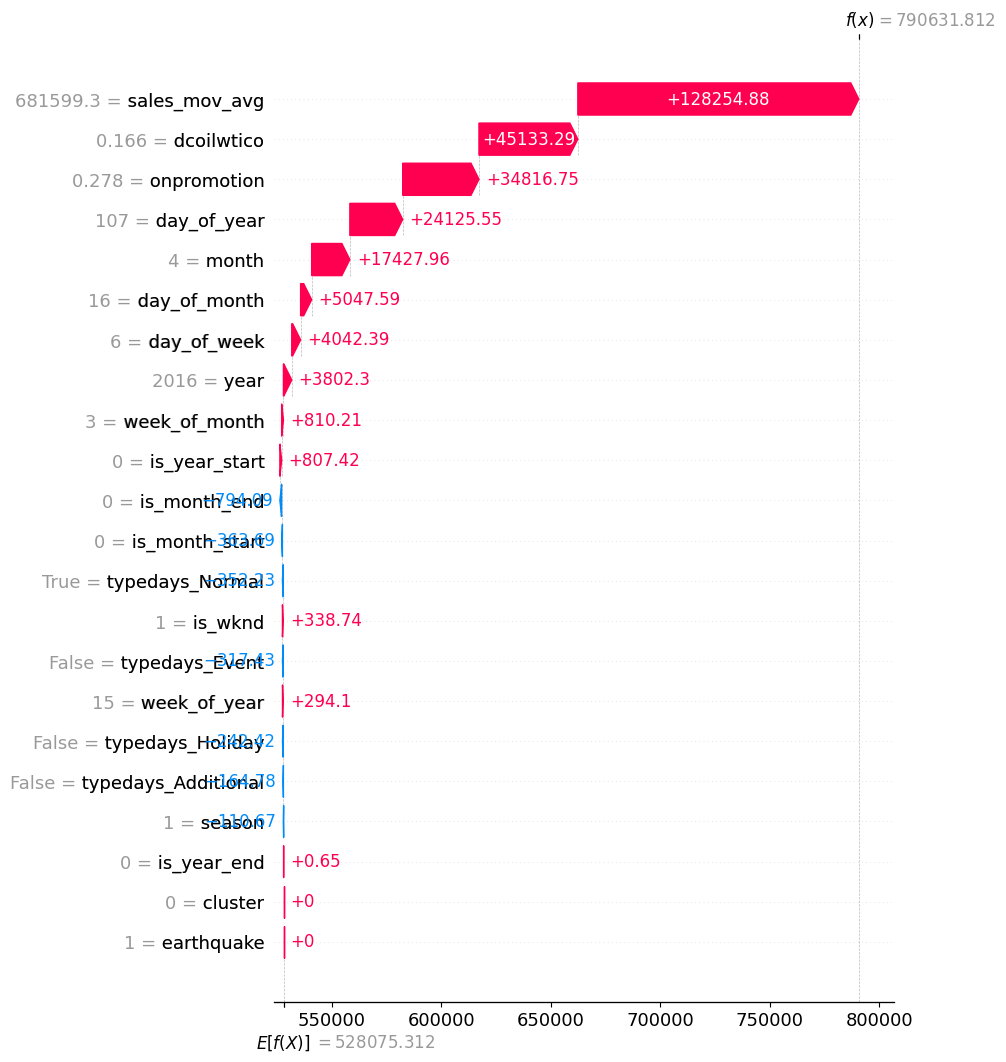

In [25]:
shap.waterfall_plot(shap_obj[1201],max_display=30)

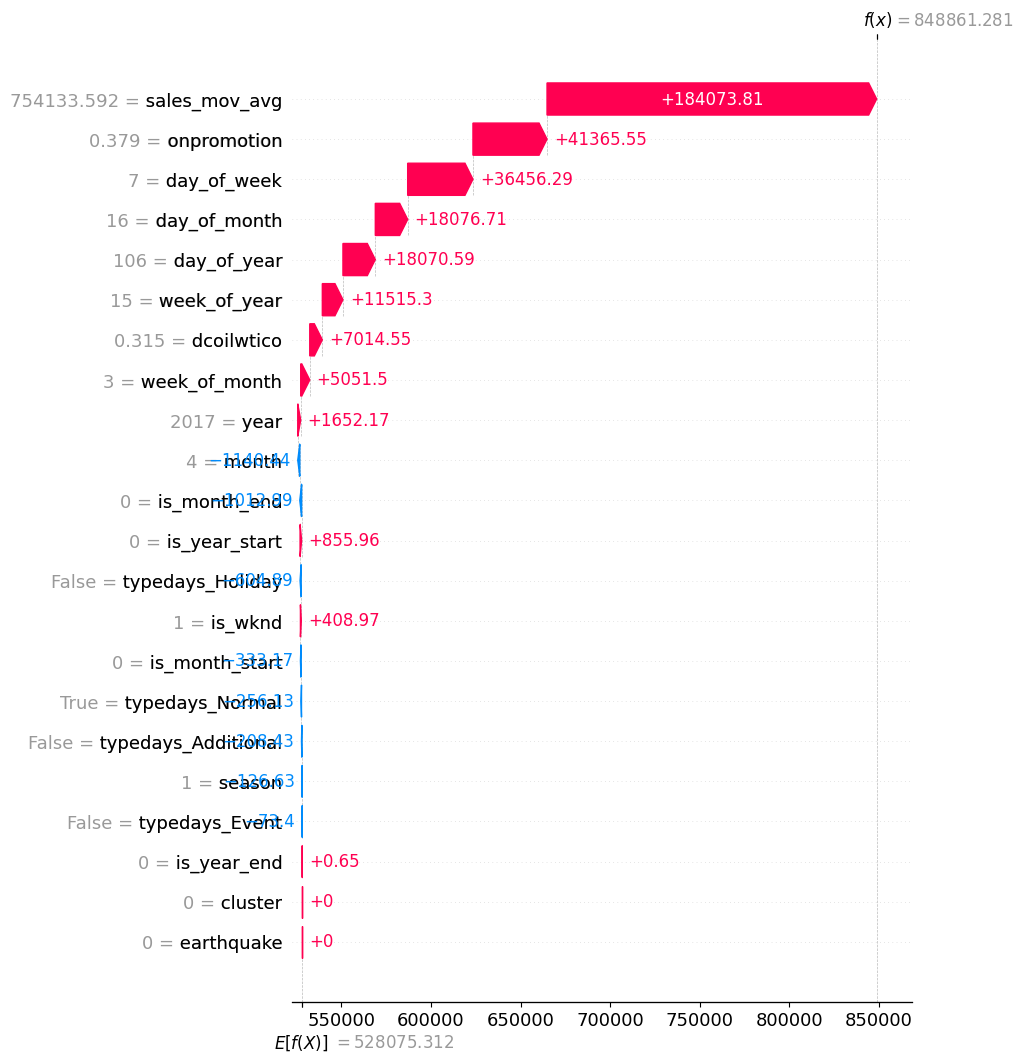

In [26]:
shap.waterfall_plot(shap_obj[1566],max_display=30)

# Comprendre l'impact de chaque variable

In [ ]:
shap.plots.scatter(shap_obj[:, 'onpromotion'], color=shap_obj[:, 'year'])

Ici, on comprends que la feature `on_promotion` n'a pas une contribution linéaire. Seules les valeurs extrêmes (pas du tout ou beaucoup de promotions) impacte les ventes.

In [ ]:
shap.plots.scatter(shap_obj[:, 'day_of_month'])

On remarque que les 1ers jours du mois on un fort impact positif sur les ventes et que cet impact devient rapidement nul. Légère hausse en milieu de mois (paye tous les 15j en equateur).

In [ ]:
shap.plots.scatter(shap_obj[:, 'sales_mov_avg'])

Relation linéaire entre les ventes et la moyenne glissante des ventes (logique)

# Interaction entre les différentes données

https://freedium.cfd/https://towardsdatascience.com/analysing-interactions-with-shap-8c4a2bc11c2a

In [ ]:
shap_interaction = explainer.shap_interaction_values(X)

In [ ]:
#Get shape of interaction values
print(np.shape(shap_interaction))

# SHAP interaction values for first date
pd.DataFrame(shap_interaction[0],index=X.columns,columns=X.columns)

L'interaction entre `dcoilwtico` et `onpromotion` a augmenté la prediction de 1497 * 2

$prediction = \sum{interaction}+(mean\_prediction)$

In [ ]:
#Get model predictions
y_pred = model.predict(X)

#Calculate mean prediction 
mean_pred = np.mean(y_pred)

#Sum of interaction values for first employee
sum_shap = np.sum(shap_interaction[0])

#Values below should be the same
print("Model prediction: {}".format(y_pred[0]))
print("Mean prediction + interaction values: {}".format(mean_pred+sum_shap))

In [ ]:
shap.dependence_plot(
    ("onpromotion", "dcoilwtico"),
    shap_interaction, X,
    display_features=X)

In [ ]:
shap.dependence_plot(
    ("onpromotion", "cluster"),
    shap_interaction, X,
    display_features=X)